<font size="6"> <b>Integrated modelling - the case of lithium-ion batteries </b><br>
<font size="3">_By Joris Baars, Newcastle University (UK), 2022_ (joris.baars@hotmail.com) <br>

The following notebook is used to model the cost, carbon footprint, performance and material criticality of different battery designs. The results are published in:

    ADD PUBLICATION

<!--     Baars, Joris & Heidrich, Oliver  -->

<center><img src='../../docs/model_overview.png' width=800/></center>


# <b> Goal and scope definition phase </b>


## <b> STEP 1. </b> Macro goal definition


## <b> STEP 2. </b> Technology system map


<center><img src='../../docs/technology_system_map.jpg' width=800/></center>


## <b> STEP 3. </b> Context description


# <b> Modelling phase </b>

Import all required packages


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging as log
import sys, os
import copy
import pyomo.environ as pyo
import sys
import openpyxl
from tqdm import tqdm
import pkg_resources

%matplotlib inline

The ODYM, battery cost and emission scripts need to be imported locally. The ODYM (Open Dynamic Material Systems Model) model is used to establish a general system and data structure and import all parameters. The latest ODYM version can be found here: https://github.com/IndEcol/ODYM


In [2]:
# path to ODYM:
sys.path.insert(
    0,
    os.path.join(
        r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\ME_battery_supply_chain\Model\ODYM"
    ),
)


import ODYM_Classes as msc
import ODYM_Functions as msf

# Logfile ODYM
log_verbosity = eval("log.INFO")
log_filename = "log_file.md"
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(), log_verbosity, log_verbosity)


# Path to the battery cost and emission scripts:
local_path = r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Bat_Sust_Model"  # ADD PATH
sys.path.insert(1, local_path)
from batt_sust_model import battery_emissions as bat_lca
from batt_sust_model import battery_cost as bat_cost


# Local path to all case study parameter files:
datapath = "."


## <b> STEP 4.</b> Data model setup

In the following block, the index table and parameter dictionary are established. This step is based on the first two steps of a ODYM model run (initialization and classification and data read). More details can be found [here](https://github.com/IndEcol/ODYM/wiki/The-ODYM-project-script) and a tutorial can be found [here](https://github.com/IndEcol/ODYM/blob/master/docs/ODYM%20Example%20and%20Tutorial%20No.%204.%20ODYM_Database.ipynb)

### Read config and classification file

In the first step, the model config (model_config.xlsx) and classification (model_classfication.xlsx) files are loaded


In [1074]:
# Read ODYM config file
config_file = openpyxl.load_workbook(datapath + "\model_config.xlsx", data_only=True)
script_config = {"Model Setting": config_file["Cover"]["D4"].value}
config_sheet = config_file["Setting_" + script_config["Model Setting"]]
project_name = config_sheet["D2"].value
ScriptConfig = msf.ParseModelControl(config_sheet, script_config)

# Parse configfile
(
    IT_Aspects,
    IT_Description,
    IT_Dimension,
    IT_Classification,
    IT_Selector,
    IT_IndexLetter,
    PL_Names,
    PL_Description,
    PL_Version,
    PL_IndexStructure,
    PL_IndexMatch,
    PL_IndexLayer,
    PrL_Number,
    PrL_Name,
    PrL_Comment,
    PrL_Type,
    ScriptConfig,
) = msf.ParseConfigFile(config_sheet, script_config, Mylog)

# Load classification file and establish classification dictionary:
Classfile = openpyxl.load_workbook(datapath + "\model_classification.xlsx", data_only=True)
Classsheet = Classfile["MAIN_Table"]
MasterClassification = msf.ParseClassificationFile_Main(Classsheet, Mylog)

ModelClassification = {}  # Dict of model classifications
for m in range(0, len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = copy.deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m], len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(":") > -1:  # range of items is taken
        RangeStart = int(EvalString[0 : EvalString.find(":")])
        RangeStop = int(EvalString[EvalString.find(":") + 1 : :])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]
    elif EvalString.find("[") > -1:  # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == "all":
        None
    else:
        Mylog.info("ITEM SELECT ERROR for aspect " + IT_Aspects[m] + " were found in datafile.</br>")
        break


INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.


### Establish index table

Next the index table is established. Each row of the index table consist of the model aspect, a unique index letter and the classification.


In [1075]:
Mylog.info("Define index table dataframe")
IndexTable = pd.DataFrame(
    {
        "Aspect": IT_Aspects,
        "Description": IT_Description,
        "Dimension": IT_Dimension,
        "Classification": [ModelClassification[Aspect] for Aspect in IT_Aspects],
        "IndexLetter": IT_IndexLetter,
    }
)  # Unique one letter indices to be used later for calculations.

# Default indexing of IndexTable
IndexTable.set_index("Aspect", inplace=True)

# Add indexSize to IndexTable:
IndexTable["IndexSize"] = pd.Series(
    [len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
    index=IndexTable.index,
)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

IndexTable


INFO (1485820818.py <<cell line: 1>>): Define index table dataframe


,Description,Dimension,Classification,IndexLetter,IndexSize
Aspect,,,,,
Regions,Battery production locations in Europe,Region,<ODYM_Classes.Classification object at 0x00000...,r,8
Process,All foreground processes,Process,<ODYM_Classes.Classification object at 0x00000...,p,141
Bat_process,Battery manufacturing process,Process,<ODYM_Classes.Classification object at 0x00000...,b,27
Goods,All foreground goods,Material,<ODYM_Classes.Classification object at 0x00000...,g,127
Internal_goods,Goods flowing inside factory,Material,<ODYM_Classes.Classification object at 0x00000...,i,15
Waste,Waste materials,Material,<ODYM_Classes.Classification object at 0x00000...,w,12
Energy,Electricity and heat,Energy,<ODYM_Classes.Classification object at 0x00000...,n,2
Elements,Chemical elements,Material,<ODYM_Classes.Classification object at 0x00000...,e,11
Emissions,ReCiPe Midpoint (H) V1.13 no LT,Satellite,<ODYM_Classes.Classification object at 0x00000...,h,17


The index table makes it easy to access the model classification items and assures that the order of the item lists is consistent throughout the model and data.<br><br> The classification items of the aspect `region` for example can be easily accessed:


In [5]:
IndexTable.loc["Regions", "Classification"].Items


['FR', 'DE', 'HU', 'NO', 'PL', 'SE', 'GB', 'European average']

In [1076]:
# Index shortcuts:
r = IndexTable.loc["Regions", "Classification"].Items
p = IndexTable.loc["Process", "Classification"].Items
g = IndexTable.loc["Goods", "Classification"].Items
D = IndexTable.loc["Battery_designs", "Classification"].Items
P = IndexTable.loc["Technical_parameters", "Classification"].Items
bp = IndexTable.loc["Bat_process", "Classification"].Items
h = IndexTable.loc["Emissions", "Classification"].Items
f = IndexTable.loc["Factors", "Classification"].Items
e = IndexTable.loc["Elements", "Classification"].Items
p_electricity = [x for x in p if "market group for electricity battery production, medium voltage" in x]
p_gas = [x for x in p if "market group for heat, district or industrial, natural gas" in x]


### Load model parameters

Next, all model datasets are imported. All datasets are stored in Excel files using the [ODYM data file template](https://github.com/IndEcol/ODYM/wiki/Data-templates) and stored as Numpy arrays in the parameter dictionary. The following data sets are imported:

| Dataset name               | Description                                                                      |
| :------------------------- | :------------------------------------------------------------------------------- |
| 3_PR_factor_price          | Production factor price per unit                                                 |
| 3_PR_material_price_unit   | External material price per unit                                                 |
| 3_PR_material_price_mass   | External material price per mass of material in US dollar                        |
| 3_PR_mineral_price         | Mineral prices and scenarios                                                     |
| 3_PR_regional_energy_price | Regional electricity and gas price                                               |
| 3_MC_materials_pack_design | Material content of battery design                                               |
| 3_MC_element_goods         | Chemical elements in battery materials                                           |
| 3_PAR_battery_parameters   | Technical pararameters and Brightway Project Parameters for all battery designs  |
| 4_PY_battery_manufacturing | Battery process yield parameters for each scenario                               |
| 4_UPI_foreground_base      | Rectangular foreground good-process matrix of first battery design (base system) |
| 4_PE_modules_base          | Gate-to-gate emissions of base system modules                                    |
| 4_PE_sensitivity_materials | High and low GWP values for material extraction for senstivity analysis          |
| 4_PAR_energy_consumption   | Battery electricity consumption parameters for each scenario                     |
| 6_CR_ESSENZ_CF_elements    | ESSENZ supply risks characterisation factors for all considered elements         |


In [7]:
Mylog.info("Reading data files into ParameterDict")

ParameterDict = {}
mo_start = 0  # set mo for re-reading a certain parameter
for mo in range(mo_start, len(PL_Names)):
    # print (PL_Names[mo] )
    try:
        ParPath = os.path.join(datapath + "\Data\ODYM_database", PL_Names[mo] + "_" + PL_Version[mo])
        Mylog.info("Reading parameter " + PL_Names[mo])
        # Do not change order of parameters handed over to function!
        MetaData, Values = msf.ReadParameterXLSX(
            ParPath,
            PL_Names[mo],
            PL_IndexStructure[mo],
            PL_IndexMatch[mo],
            PL_IndexLayer[mo],
            MasterClassification,
            IndexTable,
            IndexTable_ClassificationNames,
            ScriptConfig,
            Mylog,
            False,
        )
        ParameterDict[PL_Names[mo]] = msc.Parameter(
            Name=MetaData["Dataset_Name"],
            ID=MetaData["Dataset_ID"],
            UUID=MetaData["Dataset_UUID"],
            P_Res=None,
            MetaData=MetaData,
            Indices=PL_IndexStructure[mo],
            Values=Values,
            Uncert=None,
            Unit=MetaData["Dataset_Unit"],
        )

    except ValueError:  # If parameter file contains string (e.g. cathode material type)
        PL_Names[mo]
        Mylog.info(f"{PL_Names[mo]} includes strings")
        MetaData, Values = msf.ReadParameterXLSX(
            ParPath,
            PL_Names[mo],
            PL_IndexStructure[mo],
            PL_IndexMatch[mo],
            PL_IndexLayer[mo],
            MasterClassification,
            IndexTable,
            IndexTable_ClassificationNames,
            ScriptConfig,
            Mylog,
            False,
            string_data=True,
        )  # Add string_data is True to include string dtype in np array.
        ParameterDict[PL_Names[mo]] = msc.Parameter(
            Name=MetaData["Dataset_Name"],
            ID=MetaData["Dataset_ID"],
            UUID=MetaData["Dataset_UUID"],
            P_Res=None,
            MetaData=MetaData,
            Indices=PL_IndexStructure[mo],
            Values=Values,
            Uncert=None,
            Unit=MetaData["Dataset_Unit"],
        )

    Mylog.info("_")
Mylog.info("Reading of parameters finished.")
print("ParameterDict loaded", ParameterDict)


INFO (4186096917.py <<cell line: 1>>): Reading data files into ParameterDict
INFO (4186096917.py <<cell line: 5>>): Reading parameter 3_PR_factor_price
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 93 values was read from file for parameter 3_PR_factor_price.
INFO (ODYM_Functions.py <ReadParameterXLSX>): 24.0 of 24 values for parameter 3_PR_factor_price were assigned.
INFO (4186096917.py <<cell line: 5>>): _
INFO (4186096917.py <<cell line: 5>>): Reading parameter 3_PR_material_price_unit
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 23 values was read from file for parameter 3_PR_material_price_unit.
INFO (ODYM_Functions.py <ReadParameterXLSX>): 23.0 of 10033 values for parameter 3_PR_material_price_unit were assigned.
INFO (4186096917.py <<cell line: 5>>): _
INFO (4186096917.py <<cell line: 5>>): Reading parameter 3_PR_material_price_mass
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 67 values was read from file for parameter 3_PR_material_price_mass.

ParameterDict loaded {'3_PR_factor_price': <ODYM_Classes.Parameter object at 0x000001C47569AD90>, '3_PR_material_price_unit': <ODYM_Classes.Parameter object at 0x000001C403ECD7C0>, '3_PR_material_price_mass': <ODYM_Classes.Parameter object at 0x000001C401CC1F40>, '3_PR_mineral_price': <ODYM_Classes.Parameter object at 0x000001C403F90FD0>, '3_PR_regional_energy_price': <ODYM_Classes.Parameter object at 0x000001C403F63B80>, '3_MC_materials_pack_design': <ODYM_Classes.Parameter object at 0x000001C47AAEFF40>, '3_MC_element_goods': <ODYM_Classes.Parameter object at 0x000001C403F1D1F0>, '3_PAR_battery_parameters': <ODYM_Classes.Parameter object at 0x000001C43A0873A0>, '4_PY_battery_manufacturing': <ODYM_Classes.Parameter object at 0x000001C403F1D310>, '4_UPI_foreground_base': <ODYM_Classes.Parameter object at 0x000001C40B08B0D0>, '4_PE_modules_base': <ODYM_Classes.Parameter object at 0x000001C4587F9F10>, '4_PE_sensitivity_materials': <ODYM_Classes.Parameter object at 0x000001C40B08B100>, '4_

In [8]:
# Parameter shortcuts:
# dataframe of A default matrix:
df_A_base = pd.DataFrame(data=ParameterDict["4_UPI_foreground_base"].Values, index=g, columns=p)
# np array of default gate-to-gate emission modules
H_base = ParameterDict["4_PE_modules_base"].Values
# np array of battery design parameters
bat_design_param = ParameterDict["3_PAR_battery_parameters"].Values
# np array of battery design material content
mc_battery_designs = ParameterDict["3_MC_materials_pack_design"].Values
# material content and battery design dictionary shortcut:
mc_battery_design_dct = pd.DataFrame(data=mc_battery_designs.T, index=g, columns=D).to_dict()
bat_design_param_dct = pd.DataFrame(data=bat_design_param.T, index=P, columns=D).to_dict()


## <b>STEP 5.</b> Product design modelling

In this step the bill of materials (BOM) and technical performance parameters for all battery designs are obtained. The `battery_design` script is used for this purpose which uses BatPaC V5 and a linked vehicle model to automatically extract the desired data based on user specified design parameters:

<center><img src='../../docs/batpac_python.jpg' width=800/></center>

A example notebook of the `battery_design` model can be found [here](https://github.com/jbaars2/Batt_Sust_Model/blob/main/example%20notebooks/Battery%20design/Example%20notebook%20battery%20design.ipynb)


For this case study, A total of 5,184 battery design options for four vehicle segments are included and precalculated.

The battery design model outputs are stored in the ODYM database and include the material content (`3_MC_materials_pack_design`) of each design such as the calculated vehicle, glider, battery and cathode active material weight:


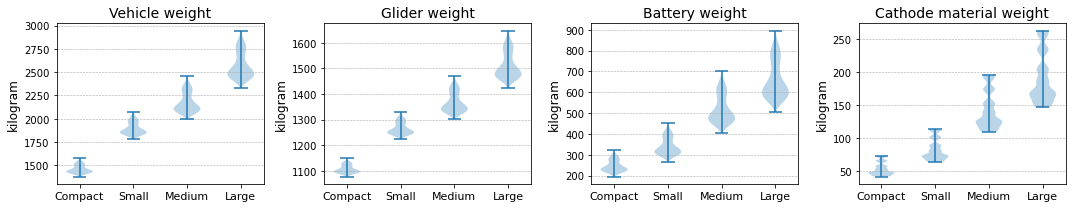

In [9]:
segments = {
    "Compact": range(0, int(len(D) / 4)),
    "Small": range(int(len(D) / 4), int(len(D) / 4) * 2),
    "Medium": range(int(len(D) / 4) * 2, int(len(D) / 4) * 3),
    "Large": range(int(len(D) / 4) * 3, int(len(D) / 4) * 4),
}


fig, ax = plt.subplots(1, 4, figsize=(15, 3))
vehicle_weight = {}
glider_weight = {}
battery_weight = {}
cam_weight = {}

for k, v in segments.items():
    vehicle_weight[k] = [bat_design_param_dct[x]["vehicle_weight"] for x in v]
    glider_weight[k] = [bat_design_param_dct[x]["glider_weight"] for x in v]
    battery_weight[k] = [bat_design_param_dct[x]["battery_system_weight"] for x in v]
    cam_weight[k] = [bat_design_param_dct[x]["positive_am_per_cell"] * bat_design_param_dct[x]["cells_per_pack"] / 1000 for x in v]

ax[0].violinplot(vehicle_weight.values())
ax[0].set_title("Vehicle weight", fontsize=14)
ax[1].violinplot(glider_weight.values())
ax[1].set_title("Glider weight", fontsize=14)
ax[2].violinplot(battery_weight.values())
ax[2].set_title("Battery weight", fontsize=14)
ax[3].violinplot(cam_weight.values())
ax[3].set_title("Cathode material weight", fontsize=14)


for i, x in enumerate(ax.flatten()):
    x.yaxis.grid(True, linestyle="--", lw=0.6)
    x.set_xticks([y + 1 for y in range(len(segments.keys()))])
    x.set_xticklabels(segments.keys(), fontsize=11)
    x.set_ylabel("kilogram", fontsize=12)
fig.tight_layout()


and technical performance parameters (`3_PAR_battery_parameters`) such as pack level density:


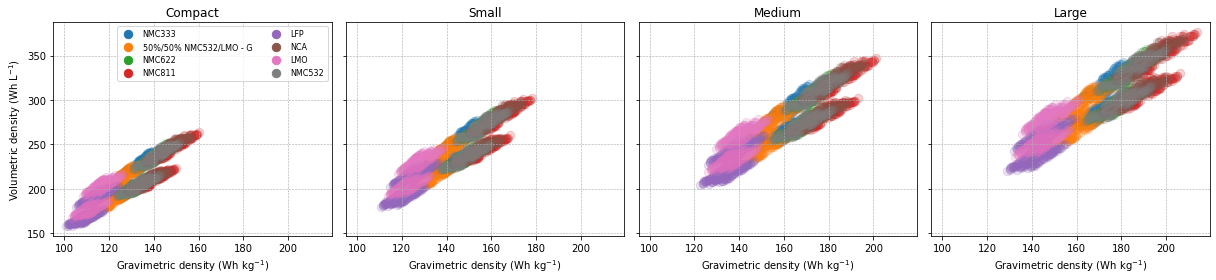

In [10]:
gr_density = {}
vol_density = {}
cam_choices = set([bat_design_param_dct[x]["electrode_pair"] for x in D])

fig, ax = plt.subplots(1, 4, figsize=(17, 4), sharey=True, sharex=True)
cmap = plt.get_cmap('tab10')

for i, k in enumerate(segments.keys()):
    for idx, cathode in enumerate(cam_choices):

        gr_density[k] = [
            bat_design_param_dct[x]["pack_usable_energy_kWh"] / bat_design_param_dct[x]["battery_system_weight"] * 1000
            for x in segments[k]
            if bat_design_param_dct[x]["electrode_pair"] == cathode
        ]
        vol_density[k] = [
            bat_design_param_dct[x]["pack_usable_energy_kWh"] / bat_design_param_dct[x]["system_volume"] * 1000
            for x in segments[k]
            if bat_design_param_dct[x]["electrode_pair"] == cathode
        ]

        ax[i].scatter(gr_density[k], vol_density[k], alpha=0.1, color=cmap(idx), s=70, label=cathode.split(" (Energy")[0].split("-G")[0])
        ax[i].set_title(k)
        ax[i].set_xlabel(r"Gravimetric density (Wh kg$^{-1}$)", fontsize=10)
        ax[i].yaxis.grid(
            True,
            linestyle="--",
            lw=0.6,
        )
        ax[i].xaxis.grid(
            True,
            linestyle="--",
            lw=0.6,
        )
ax[0].set_ylabel(r"Volumetric density (Wh L$^{-1}$)", fontsize=10)
leg = ax[0].legend(fontsize=8, ncol=2)
for lh in leg.legendHandles:
    lh.set_alpha(1)
fig.tight_layout()


A vehicle model was linked to BatPaC based on [Yelin et al., 2017](https://www.sciencedirect.com/science/article/abs/pii/S0378775317300368), whereby the battery weight and required battery energy are based on a desired vehicle range and segment specific vehicle characteristics.

For the case study the following input parameters where used for the vehicle model:

| parameter              | unit          | Compact | Small  | Medium | Large |
| ---------------------- | ------------- | ------- | ------ | ------ | ----- |
| rolling resistance     | N             | 101.86  | 110.59 | 136    | 209.4 |
| rotation resistance    | N/(m/s)       | 3.42    | -1.99  | 3.73   | 2.59  |
| aerodynamic resistance | N/(m/s)$^{2}$ | 0.37    | 0.46   | 0.41   | 0.47  |
| distance               | km            | 200     | 322    | 411    | 460   |
| auxiliary power        | W             | 475     | 575    | 715    | 775   |
| motor power            | kW            | 55      | 150    | 150    | 209   |

<br>

Comparing the modelled electricity consumption and vehicle weight with real values based on registration data from the European Environmental Agency illustrates that the modelled results match the real values:


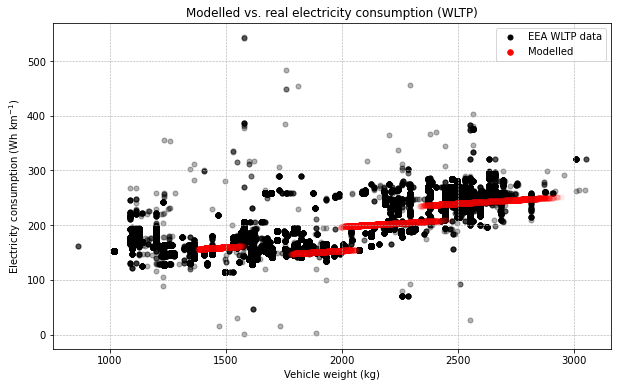

In [11]:
# Import prepared BEV registration data from the European Environmental Agency:
eea_2020 = pd.read_csv(".\data\\result_comparison\EEA_BEV_2020.gzip", compression="gzip", low_memory=False)
ener_cons_eea = eea_2020["z (Wh/km)"]
veh_mass = eea_2020["m (kg)"]

# Calculate vehicle electricity consumption from modelled data:
vehicle_weight = [bat_design_param_dct[x]["vehicle_weight"] for x in D]
ener_cons_modelled = [bat_design_param_dct[x]["pack_usable_energy_kWh"] / bat_design_param_dct[x]["Vehicle_range_km"] * 1000 for x in D]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(veh_mass, ener_cons_eea, color="black", s=25, alpha=0.3, label="EEA WLTP data")
ax.scatter(vehicle_weight, ener_cons_modelled, color="r", s=30, alpha=0.03, label="Modelled")

ax.set_ylabel(r"Electricity consumption (Wh km$^{-1}$)")
ax.set_xlabel("Vehicle weight (kg)")
ax.set_title("Modelled vs. real electricity consumption (WLTP)")
ax.xaxis.grid(
    True,
    linestyle="--",
    lw=0.6,
)
ax.yaxis.grid(
    True,
    linestyle="--",
    lw=0.6,
)
leg = plt.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)


And comparing the modelled result with real battery weights based on BEVs registered in 2017 and 2020


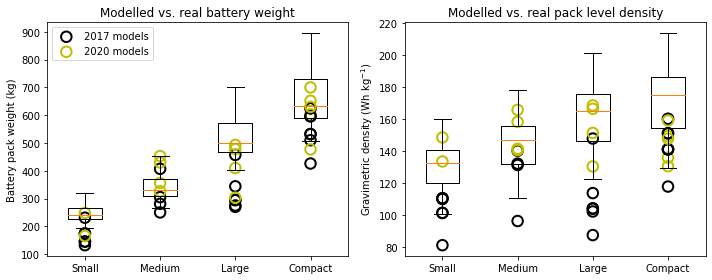

In [12]:
import string

# import battery weight data:
battery_wt_real = pd.read_excel(".\data\\result_comparison\pack_weight_2017_2020.xlsx", sheet_name="values")


fig, ax = plt.subplots(1, 2, figsize=(10, 4))

density_usable = {}
weight = {}
density_nominal = {}
for i, k in enumerate(segments.keys()):

    density_usable[k] = [
        bat_design_param_dct[x]["pack_usable_energy_kWh"] / bat_design_param_dct[x]["battery_system_weight"] * 1000 for x in segments[k]
    ]
    weight[k] = [bat_design_param_dct[x]["battery_system_weight"] for x in segments[k]]
ax[0].boxplot(weight.values())
ax[1].boxplot(density_usable.values())
for index, row in battery_wt_real.iterrows():
    x = string.ascii_lowercase.index(row["Segment"].lower())
    y = row["battery weight"]
    y1 = row["energy density"] * 1000
    if row["year"] == 2017:
        label = "2017 models"
        color = "k"
    else:
        label = "2020 models"
        color = "y"
    ax[1].scatter(x + 1, y1, color=color, label=label, s=110, facecolor="None", linewidth=2)
    ax[0].scatter(x + 1, y, color=color, label=label, s=110, facecolor="None", linewidth=2)
ax[0].set_xticklabels({"Compact", "Small", "Medium", "Large"})
ax[1].set_xticklabels({"Compact", "Small", "Medium", "Large"})

handles, labels = ax[0].get_legend_handles_labels()
lgd = dict(zip(labels, handles))
ax[0].legend(
    lgd.values(),
    lgd.keys(),
    fontsize=10,
    markerscale=1,
    loc="upper left",
)
ax[0].set_ylabel(r"Battery pack weight (kg)")
ax[0].set_title(r"Modelled vs. real battery weight")

ax[1].set_ylabel(r"Gravimetric density (Wh kg$^{-1}$)")
ax[1].set_title(r"Modelled vs. real pack level density")
fig.tight_layout()


The modelled battery weight and density match the real values relatively well. This is especially the case for vehicles registered post 2020, highlighting the improvements made in terms of energy density. For example,, the VW E-golf in 2017 had a density of 103 wh/kg ([36 kWh and battery weight 349 kg](https://dis.epa.gov/otaqpub/publist1.jsp)) as compared to 166 Wh/kg for the VW ID.4 ([82 kWh and battery weight of 493](https://www.vwpress.co.uk/assets/documents/original/29187-ID4presspackMarch2021.pdf)).


## <b> Step 6.</b> foreground system modelling

The foreground system consists of all material and energy activity flows affected by the battery design choice:

<center><img src='../../docs/flow_map.png' width=1200/></center>

Due to the size constraints of Excel, the foreground matrix ($\bf{A_{foreground}}$) is not imported from the database but instead calculated and stored as a nested matrix. <br>

The calculation is based on process formula and parameters as established in Brightway


In [13]:
# Selecting process yield and energy consumption scenarios:

# energy
process_parameters = {
    param: process_yield
    for param, process_yield in zip(
        IndexTable.loc["Process_parameter", "Classification"].Items,
        ParameterDict["4_PY_battery_manufacturing"].Values[:, 0],  # default scenario is 0
    )
}
# energy consumption
process_parameters.update(
    {
        param: energy_consumption
        for param, energy_consumption in zip(
            IndexTable.loc["Process_parameter", "Classification"].Items,
            ParameterDict["4_PAR_energy_consumption"].Values[:, 1],  # default scenario is 1
        )
        if energy_consumption > 0
    }
)

# Import other default project parameters as used in Brightway
data_path_model = pkg_resources.resource_filename("batt_sust_model", "data/")

default_parameters = pd.read_excel(data_path_model + "bw_default_project_parameters.xlsx", index_col=0).fillna(0).T.to_dict()


The foreground matrix for each battery design is calculated based on the defined process parameters and battery design parameters as solved with BatPaC. <br>


In [14]:
# Empty np array of size all pack design * materials * processes
A_matrix_nested = np.zeros((len(D), len(g), len(p)))

A_base = df_A_base.copy(deep=True)


# dictionary of the battery design parameters for all designs in non-alphanumeric parameters
param_dict_all = {}

# iterate over all pack designs and solve the process formulas based on specific pack parameters and process formulas:
for design in tqdm(D):
    param_dict_all[design] = bat_lca.parameter_dictionary(
        mc_battery_design_dct[design],
        process_parameters,
        bat_design_param_dct[design],
        default_parameters,
    )
    A_matrix_temp = bat_lca.calculate_modular_A(A_base, param_dict_all[design])

    A_matrix_nested[design] = A_matrix_temp


100%|██████████| 20736/20736 [01:49<00:00, 190.05it/s]


The result is a multi-dimensional numpy array of size Design X Goods X Processes:


In [15]:
A_matrix_nested.shape


(20736, 127, 141)

Using the ODYM index table the material flows for each battery design can be easy obtained. For example, all energy input for the production of battery design #30 can be obtained as follow:


In [16]:
energy = A_matrix_nested[30, :, [p.index(process) for process in bp]][
    :,
    [
        g.index("electricity for battery production, medium voltage"),
        g.index("heat, district or industrial, natural gas for battery production"),
    ],
]

df_electr = pd.DataFrame(energy, index=bp, columns=["Electricity (kWh)", "Natural gas (MJ)"]).abs()
(df_electr[df_electr["Electricity (kWh)"] > 0].dropna().T.round(2).sort_values(by="Electricity (kWh)", axis=1) / 33)


,mixing anode materials,final electrode drying,cathode slitting,anode slitting,mixing cathode materials,anode coating and drying,cell stacking,cathode calendering,anode calendering,cathode coating and drying,electrolyte filling and sealing,module and pack assembly,cell formation
Electricity (kWh),0.024242,0.033030,0.042121,0.042121,0.044848,0.116970,0.127879,0.155455,0.155455,0.370909,2.645455,2.699091,7.152121
Natural gas (MJ),0.000000,3.353333,0.000000,0.000000,0.000000,4.713333,0.000000,0.000000,0.000000,14.925455,17.632424,0.000000,1.223636


## <b>STEP 7.</b> Satellite accounts

Satellite accounts are linked to the identified impact indicators and calculated using different analytical methods. In this case study, four satellite accounts are included and calculated with the following methods:

| Impact indicator      | Satellite account (notation)                                  | Unit                                | Calculation method                             |
| --------------------- | ------------------------------------------------------------- | ----------------------------------- | ---------------------------------------------- |
| Carbon footprint      | Global warming potential ($\mathbf{h}$)                       | kg CO<sub>2</sub> eq.               | Life cycle impact assessment                   |
| Battery cost          | Value added ($\mathbf{v}$)                                    | US$                                 | Life cycle costing                             |
| Material criticality  | Substance flows ($\mathbf{E}$) and value added ($\mathbf{v}$) | kg & US$                            | Substance flow analysis and life cycle costing |
| Technical performance | Pack level gravimetric energy density ($\mathbf{p}$)          | Wh<sub>usable</sub> kg<sup>-1</sup> | Technical performance model (BatPaC)           |


### Global warming potential ($\mathbf{h}$)


The global warming potential (GWP) refers to all cradle-to-gate carbon emissions and is calculated based on the modular LCA approach (see also [Steubing et al., 2016](https://link.springer.com/article/10.1007/s11367-015-1015-3)). The GWP for each process in the foreground matrix are thereby pre-calculated to obtain the emissions of that activity ($h$) using the matrix based calculation for life cycle impact assessment. The result is a vector of the gate-to-gate GWP of the foreground processes ($\bf{h}$). 


The modular emissions for all foreground processes are precalculated in Brightway2 using the ReCiPe Midpoint V1.13 impact category. 

Exchanges that are present in the foreground matrix are thereby cut-off from each activity. For example, electricity inputs for battery production are cut-off from the battery production processes. The fully parameterised Brightway model to calculate battery production emissions based on specific BatPaC battery designs is available in the GitHub repository. An example notebook on how to link BatPaC to the Brightway model and establish the modular database can be viewed [here](https://github.com/jbaars2/Batt_Sust_Model/blob/main/example%20notebooks/Battery%20emissions/Example%20LCA%20notebook.ipynb)





The functional unit of each gate-to-gate module is set to one unit (e.g. 1 kg, kWh or MJ). All gate-to-gate emissions of the foreground processes are stored in the `4_PE_modules_base` datasets. The dataset includes for example all regional electricity production processes:

In [17]:
pd.DataFrame(ParameterDict["4_PE_modules_base"].Values, IndexTable.loc['Emissions', 'Classification'].Items, p).loc["('ReCiPe Midpoint (H) V1.13 no LT', 'climate change', 'GWP100')", [x for x in p if 'electricity' in x]]

market group for electricity battery production, medium voltage, DE                  0.571878
market group for electricity battery production, medium voltage, European average    0.350385
market group for electricity battery production, medium voltage, FR                  0.105445
market group for electricity battery production, medium voltage, GB                  0.332830
market group for electricity battery production, medium voltage, HU                  0.441103
market group for electricity battery production, medium voltage, NO                  0.019578
market group for electricity battery production, medium voltage, PL                  0.975914
market group for electricity battery production, medium voltage, SE                  0.005945
Name: ('ReCiPe Midpoint (H) V1.13 no LT', 'climate change', 'GWP100'), dtype: float64

In [18]:
# The imported modular h base contains all ReCiPe impact indictors, in this study we only select GWP
impact_cat = 2  # GWP100

# h nested array modular emissions by repeating the modular emission matrix by the total amount of designs:
h_nested = np.tile(H_base[impact_cat], (len(D),1))


### Value added ($\mathbf{v}$)

The value added is calculated with the `battery_cost.py` script. The script can be used as stand-alone model to calculate battery cost and is largely based on the BatPaC cost model. A example notebook of the model can be found [here](https://github.com/jbaars2/Batt_Sust_Model/blob/main/example%20notebooks/Battery%20cost/Example%20notebook%20battery%20cost.ipynb). <br>


The value added is based on two sub-satellite accounts: the factor cost ($\bf{F}$) and material cost ($\bf{C}$).


#### Battery production factor cost ($\mathbf{F}$)

First, the value added for battery production ($\mathbf{v}_{bat}$) is calculated based on the primary production factor requirements, including building/land, labour and capital requirement. This is calculated by multiplying the physical factor matrix ($\mathbf{F'}$) and a vector of factor cost ($\mathbf{\pi}$) as described by Duchin and Levin (2011):
$$\mathbf{v}_{bat}= \mathbf{F}_{bat}\mathbf{\pi}$$

The battery production process factor requirement is calculated with the battery_cost.py script and the `factors_battery_production` formula. The underlying calculations are based on BatPaC and account for the manufacturing output scale.


In [661]:
# Default BatPaC capacity of 500,000 packs per year is used:
manufacturing_capacity = 500000

# Change the capacity parameter for all battery designs
for x in param_dict_all.keys():
    param_dict_all[x]["battery_manufacturing_capacity"] = manufacturing_capacity

# Returns the nested F matrix with factors (rows) for all battery production processes (columns)
F_physical_nested_temp = bat_cost.factors_battery_production(param_dict_all, run_multiple=True, return_index=f, return_columns=bp)

# Include all foreground processes:
F_physical_nested = np.zeros([len(D), len(f), len(p)])

F_physical_nested[:, :, [p.index(process) for process in set(bat_cost.process_mapping.values())]] = F_physical_nested_temp


100%|██████████| 20736/20736 [03:32<00:00, 97.39it/s] 


The physical factor requirements (land and labour) are multiplied with the factor prices ($\pi$) to obtain the monetary factor requirements. <br>

The price factors are country specific. Capital is multiplied by 1,000,000 to convert from million $


In [662]:
df_factor_cost = pd.DataFrame(ParameterDict["3_PR_factor_price"].Values, index=f, columns=r).round(2)
df_factor_cost.insert(0, "Unit", ["$/m2", "$/hr", "$/$"])
df_factor_cost


,Unit,FR,DE,HU,NO,PL,SE,GB,European average
land,$/m2,2380.08,2213.95,1219.94,3683.20,1503.39,3074.60,2291.40,2338.08
labour,$/hr,43.25,42.18,11.73,59.48,12.68,43.25,33.77,35.19
capital,$/$,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00


Operating expenses (e.g. R&D investments and depreciation rates) are allocated to the factor cost based on the multipliers for overhead to basic cost calculation as used in BatPaC.


In [663]:
bat_cost.factor_overhead_multiplier(return_index=f)


{'land': 0.153252, 'labour': 1.8664800000000001, 'capital': 0.253704}

Multiplying physical factor matrix by the region specific factor prices using np.einsum to establish the monetary factor matrix:


In [664]:
#Selected country:
country = 'European average'

factor_cost = ParameterDict["3_PR_factor_price"].Values[:, IndexTable.loc["Regions", "Classification"].Items.index(country)]
factor_cost

F_monetary_nested = np.einsum(
    "dfp, f -> dfp", F_physical_nested, (factor_cost * list(bat_cost.factor_overhead_multiplier(return_index=f).values()))
)
# divided by the manufacturing capacity to obtain the factor cost per pack:
F_monetary_nested = F_monetary_nested / manufacturing_capacity


The resulting matrix represents the value added in terms of land, labour and capital requirement for each battery production process. <br>

For battery design 30 for example, the value added for each battery production process is:


Text(0.5, 0, 'Cost ($)')

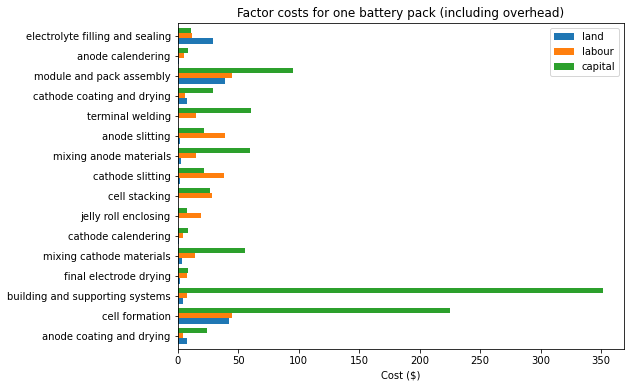

In [24]:
pd.DataFrame(F_monetary_nested[30,:, [p.index(x) for x in bp]].T,  f, bp).drop([x for x in bp if 'waste' in x or 'scrap' in x], axis=1).round(3).T.plot.barh(title='Factor costs for one battery pack (including overhead)', figsize=(8,6), width=0.8 );
plt.xlabel ('Cost ($)')

#### Battery material cost ($\mathbf{C}$)

The second step of the value added layer are the value added calculation outside the battery factory. This refers to the material cost ($\mathbf{C}$) and is based on the computational structure of life cycle cost as proposed by Heijungs et al. (2012) and Moreau and Weidema (2015) to obain the monetary equivalant of the technology matrix:

$$\mathbf{C} = \mathbf{A}\mathbf{\alpha}$$

<br>

The general material cost can obtained from the technology matrix ($\mathbf{A}$) and the material cost vector ($\mathbf{\alpha}$).

The material cost vector consist the mass prices ($\mathbf{\alpha_{mass}}$) obtained from a variety of sources:


In [25]:
df_pr_material_mass = pd.Series(ParameterDict["3_PR_material_price_mass"].Values, g)
pd.DataFrame(df_pr_material_mass[df_pr_material_mass > 0], columns=["$/kg"]).head(10)


,$/kg
anode active material (natural graphite),9.11662
anode active material (SiO),60.00000
anode active material (synthetic graphite),12.15058
anode binder (CMC),5.00000
anode binder additive (SBR),5.00000
anode carbon black,3.60000
anode current collector Cu (10um),14.15479
anode current collector Cu (11um),14.15479
anode current collector Cu (12um),14.15479
anode current collector Cu (13um),14.15479


And unit prices ($\mathbf{\alpha_{unit}}$) obtained from BatPaC. <br>

The cell container for example, is calculated based on a mass price and the total cells per pack:


In [26]:
df_pr_unit = pd.DataFrame(ParameterDict["3_PR_material_price_unit"].Values, g, P)
df_pr_unit = df_pr_unit[(df_pr_unit != 0).any(axis=1)]
df_pr_unit.loc["cell container"].sort_values()


electrode_pair             0.0
calculate_fast_charge      0.0
max_charging_time          0.0
available_energy           0.0
vehicle_weight             0.0
                          ... 
negative_electrode_area    0.0
positive_electrode_area    0.0
total_packs_vehicle        0.0
pack_energy                0.0
cells_per_pack             0.2
Name: cell container, Length: 79, dtype: float64

In [27]:
# Restructure unit prices to dictionary:
dict_pr_unit = {}
for k, v in df_pr_unit.T.to_dict().items():
    dict_pr_unit[k] = {}
    for k2, v2 in v.items():
        if v2 != 0:
            dict_pr_unit[k][k2] = v2


In [1021]:
C_matrix_nested = np.load(r"C:\Users\Joris\Desktop\C_matrix_nested.npy")


In [34]:
# Empty C matrix
C_matrix_nested = np.zeros((len(D), len(g), len(p)))


C_matrix_nested = bat_cost.material_cost_matrix(
    A_matrix_nested,
    df_pr_material_mass,
    dict_pr_unit,
    system_design_parameters=param_dict_all,
    run_multiple=True,
    process_columns=p,
    material_rows=g,
)


100%|██████████| 20736/20736 [27:50<00:00, 12.41it/s]


In [963]:
# Include energy cost for all regions:
for region in r:
    electricity_price = ParameterDict["3_PR_regional_energy_price"].Values[0, r.index(region)]
    gas_price = ParameterDict["3_PR_regional_energy_price"].Values[1, r.index(region)]
    C_matrix_nested[
        :,
        g.index("electricity for battery production, medium voltage"),
        p.index(f"market group for electricity battery production, medium voltage, {region}"),
    ] = electricity_price
    C_matrix_nested[
        :,
        g.index("heat, district or industrial, natural gas for battery production"),
        p.index(f"market group for heat, district or industrial, natural gas, {region}"),
    ] = gas_price


In [888]:
ParameterDict["3_PR_regional_energy_price"].Values[0, ]

array([0.11263617, 0.18069804, 0.1098566 , 0.09058666, 0.10407148,
       0.08359003, 0.17579531, 0.12246204])

#### Total value added ($\mathbf{v}$) 

The total value added vector is now obtained:

In [1022]:
# process value added based on factor requirements:
v_nested = np.sum(F_monetary_nested, 1)
# material process value added based on C matrix:
v_nested[:] += np.sum(C_matrix_nested, 1)


### Substance flow layer ($\mathbf{E}$)

The substance flow matrix ($\mathbf{E}$) is calculated by multiplying the technology matrix ($\mathbf{A}$) with the elemental content of goods stored in the transmission coefficient matrix ($\mathbf{\tau}$) (Löfving, 2006):

$$
\mathbf{E} = \mathbf{A}_{g,p} \mathbf{\tau}_{e,g}
$$

The transmission coefficient matrix contains the faction of the considered elements in each good. <br>

For example, 1kg of cathode active materials contains the following elements:


Text(0.5, 0, 'kg per kg material')

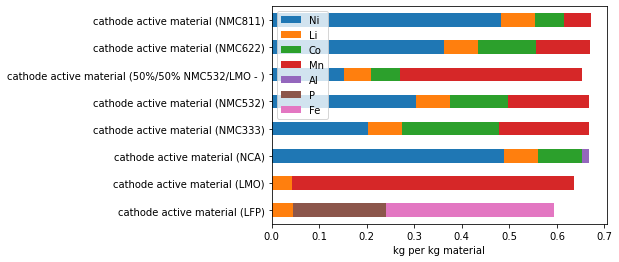

In [38]:
pd.DataFrame(ParameterDict["3_MC_element_goods"].Values, e, g)[[x for x in g if "cathode active material" in x]].drop(
    ["C", "Cu", "Si", "All"]
).sort_values(by="cathode active material (NMC811)", ascending=False).T.plot.barh(stacked=True)
plt.xlabel("kg per kg material")


In [ ]:
pd.DataFrame(ParameterDict["3_MC_element_goods"].Values, e, g)[[x for x in g if "cathode active material" in x]]

,cathode active material (LFP),cathode active material (LMO),cathode active material (NCA),cathode active material (NMC333),cathode active material (NMC532),cathode active material (50%/50% NMC532/LMO - ),cathode active material (NMC622),cathode active material (NMC811)
All,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Li,0.043991,0.043370,0.072219,0.071985,0.071870,0.057620,0.071591,0.071329
Al,0.000000,0.000000,0.014038,0.000000,0.000000,0.000000,0.000000,0.000000
Si,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P,0.196311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mn,0.000000,0.593035,0.000000,0.189764,0.170686,0.381861,0.113348,0.056467
Fe,0.354019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Co,0.000000,0.000000,0.091986,0.203546,0.122055,0.061028,0.121580,0.060568
Ni,0.000000,0.000000,0.488759,0.202786,0.303998,0.151999,0.363379,0.482738
Cu,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [39]:
# Multiply the transmission by the nested technology matrix using np.einsum:

E_matrix_nested = np.einsum("ijk, ej -> iek", A_matrix_nested, ParameterDict["3_MC_element_goods"].Values)


For example, the total substance demand to produce one battery pack (design #30) are:


In [40]:
design = 30

print(" Battery size:", int(param_dict_all[design]["pack_energy_kWh"]), "kWh\n", "Cathode chemistry: ", param_dict_all[design]["electrode_pair"])

df_temp = pd.DataFrame(np.sum(E_matrix_nested[design, :, [p.index(x) for x in bp]], 0).round(2), e, columns=[f"Design {design}"]).abs()
df_temp["unit"] = "kg"
df_temp[df_temp[f"Design {design}"] > 0]


 Battery size: 33 kWh
 Cathode chemistry:  LFP-G (Energy)


,Design 30,unit
Li,3.40,kg
Al,16.68,kg
P,14.69,kg
Fe,75.48,kg
Cu,23.75,kg


## <b> STEP 8.</b> Solution & visualisation 
The next step is to solve the model and visualise the results for all impact indicators. We provide three examples of solving and visualisation:


* <b> Interactive dashboard </b> - Interactive dashboard to explore impact of user defined design: https://battery-sustainability-app.herokuapp.com/
* <b> All designs </b> -  Overview of the impact results for all design alternatives
* <b> Optimal design </b> - Single and multi-objective optimisation to obtain optimal design



### <b>Solution 1:</b> All designs

In this first example, the impacts are iteratively calculated for each design. To obtain the solution of all pack designs we first obtain the process scaling factors ($\bf{s_d}$) for each design ($d$) using established life cycle inventory model as described by Heijungs and Suh (2002) :  

$$ \bf{s_{d,p}} = (\bf{A'}_{d,g,p})^{-1} \bf{y}_{d,g}$$

Where $\bf{A'}$ refers to the square foreground technology matrix for a specific battery design and $\bf{f}$ to the supply vector. 


In [41]:
# First, the relevant production needs to be selected to asssure the A and h matrices are square -> region specific energy need to be excluded:
country = "European average"

electricity_choice = f"market group for electricity battery production, medium voltage, {country}"
gas_choice = f"market group for heat, district or industrial, natural gas, {country}"

process_selection = []

for x in p:
    if x == electricity_choice:
        process_selection.append(p.index(x))
    elif x == gas_choice:
        process_selection.append(p.index(x))
    elif x in p_electricity or x in p_gas:
        continue
    else:
        process_selection.append(p.index(x))

p_selection_name = [p[i] for i in process_selection]


In [42]:
# Empty np array # Empty nested np array where the first element refers to all battery designs and the second to all processes
s_nested = np.zeros([len(D), len(process_selection)])

# Calculate scaling vector for each design based on the life cycle inventory model:
for design in D:
    # Pack weight of each design as functional unit:
    fu = A_matrix_nested[design, g.index("battery pack"), p.index("module and pack assembly")]
    # Inverse the A matrix of the specific design:
    A_inv = np.linalg.pinv(A_matrix_nested[design, :, process_selection].T)
    # Establish final product demand vector for 1 battery based on pack weight
    y = np.zeros(len(g))
    y[g.index("battery pack")] = fu
    # Obtain the scaling vector
    s_nested[design] = A_inv.dot(y)


The scaling factors for all foreground processes and battery designs can now be obtained. The scaling factor of all battery production factors refer to 1 as the output of each process in the foreground matrix was scaled to battery pack weight of each design

In [43]:
pd.DataFrame(s_nested,D,p_selection_name ).head(5).round(2)[pd.DataFrame(s_nested,D,p_selection_name ).head(5).round(2)>0].dropna(axis=1)

,anode active material (synthetic graphite) import,anode binder (CMC) production,anode binder additive (SBR) production,anode calendering,anode coating and drying,anode current collector Cu (6um) production,anode electrode scrap handling,anode slitting,battery jacket aluminium,battery jacket insulation,...,"sheet rolling, aluminium","sheet rolling, steel",spacer for gas release production,terminal welding,waste anode current collector Cu handling,waste anode slurry handling,waste cathode current collector Al handling,waste cathode slurry handling,"market group for electricity battery production, medium voltage, European average","market group for heat, district or industrial, natural gas, European average"
0,33.41,0.41,0.27,1.0,1.0,8.78,1.0,1.0,17.96,0.96,...,9.92,31.29,0.1,1.0,1.0,1.0,1.0,1.0,410.29,1103.58
1,33.55,0.41,0.27,1.0,1.0,9.91,1.0,1.0,20.75,1.12,...,15.09,35.75,0.1,1.0,1.0,1.0,1.0,1.0,415.26,1109.97
2,25.85,0.33,0.22,1.0,1.0,8.83,1.0,1.0,17.53,0.94,...,9.31,30.77,0.1,1.0,1.0,1.0,1.0,1.0,401.14,1036.89
3,25.95,0.33,0.22,1.0,1.0,10.00,1.0,1.0,20.22,1.09,...,14.36,35.06,0.1,1.0,1.0,1.0,1.0,1.0,406.04,1043.84
4,20.65,0.28,0.19,1.0,1.0,8.85,1.0,1.0,17.09,0.91,...,8.91,30.15,0.1,1.0,1.0,1.0,1.0,1.0,394.53,990.53


The battery cost ($v$) and carbon footprint ($h$) can be obtained by multiplying the scaling vector for each design with the satellite account:

In [1023]:
# Multiply all layers by the scaling vector
h_nested_scaled = np.einsum("ij, ij -> ij", s_nested, h_nested[:,process_selection])
v_nested_scaled = np.einsum("ij, ij -> ij", s_nested, v_nested[:, process_selection])

The material criticality ($c$) is based on the criticality calculation for product systems as described by [Lütkehaus et al., (2021)](https://link.springer.com/article/10.1007/s11367-021-02002-z). The economic product importance (EPI) and supply disruption probability (SPD) indicators are used to calculate the criticality score for each design and all considered elements:

$$ c = \sum_{e} \mathbf{EPI}_{e,p} \times \mathbf{SDP}_e $$

The EPI refers to the relative cost for each element as compared to the total battery cost. The EPI is therefore calculated by multiplying the price of elements ($\mathbf{\Omega}_e$) with the element inflows (negative) for battery production ($\mathbf{E}_{e,bp}$), divided by the total battery cost ($v$):

\begin{equation}
\mathbf{EPI}_{e} =\frac{ \mathbf{\Omega}_e(\mathbf{E}_{e, bp}\times-1)}{v}
\end{equation}



$\mathbf{E}_{e,bp}$ refers to the transmission coefficient matrix for the battery production processes. As all battery production processes have a scaling factor of 1, we do not have to multiply this matrix with $\mathbf{s}$



In [208]:
df_mineral_price = pd.DataFrame(
    ParameterDict["3_PR_mineral_price"].Values, e, IndexTable.loc["Mineral_price_scenario", "Classification"].Items
)

df_mineral_price

,low,used,high
All,0.000000,0.000000,0.000000
Li,22.484376,361.781685,361.781685
Al,1.459930,2.807500,3.691880
Si,1.168326,3.222060,4.300834
P,2.813461,1.264473,27.809085
Mn,3.309330,3.670108,14.605292
Fe,0.109710,0.188645,0.633500
Co,8.900248,72.356696,114.225309
Ni,7.052990,30.339662,65.131492
Cu,2.013115,9.720500,11.353492


In [474]:
# Index for battery production processes:
battery_production_index = [p_selection_name.index(i) for i in bp]

#Calculate EPI:
EPI_scaled = np.einsum('ijk, j-> ij', E_matrix_nested[:, :, battery_production_index], df_mineral_price["used"].values)*-1
#Obtain the fractional cost of each element based on the total battery cost:
# EPI_scaled = (EPI_scaled./v_nested_scaled.sum(axis=1)).T

For example, the EPI for the elements in the first 10 different battery designs is:

<AxesSubplot:ylabel='Economic product importance'>

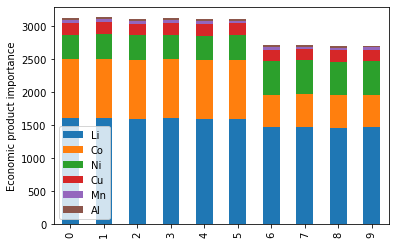

In [344]:
pd.DataFrame(EPI_scaled, D,e).loc[range(0,10)].drop(['All','Fe', 'Si', 'C', 'P'], axis=1).sort_values(by=0, ascending=False, axis=1).plot.bar(stacked=True, ylabel='Economic product importance')

The second element of the criticality indicator calculation, the supply disruption probability (SPD) is obtained by multiplying the elemental inflows for battery production with the ESSENZ characterization factors (CF) (Bach et al., 2016):

\begin{equation}
\mathbf{SDP}_{e, p} = (\mathbf{E}_{e,bp}\times-1) \mathbf{ESSENZ}_{e}
\end{equation}

The ESSENZ CF are obtained [here](https://www.tu.berlin/en/see/research/data-sets-methods-and-tools/essenz-method/) and stored in the ODYM database:

In [48]:
pd.DataFrame(ParameterDict["6_CR_ESSENZ_CF_elements"].Values, e, columns=['ESSENZ CF'])

,ESSENZ CF
All,0.000000e+00
Li,9.117922e+10
Al,1.239331e+08
Si,1.291250e+09
P,7.104455e+07
Mn,5.000520e+08
Fe,2.134463e+06
Co,9.639504e+10
Ni,3.226556e+09
Cu,1.612863e+08


In [475]:
#Calculate the SPD:
SCP_scaled = np.einsum('ijk, j-> ij', E_matrix_nested[:, :, battery_production_index],  ParameterDict["6_CR_ESSENZ_CF_elements"].Values[:,0])*-1       

#And multiply with the EPI to obtain the total criticality score of each design:
c_nested_scaled = np.einsum('ij, ij->i', EPI_scaled,  SCP_scaled)
                   

For example, comparing the EPI and SPD of a NMC333 and NCA battery design:

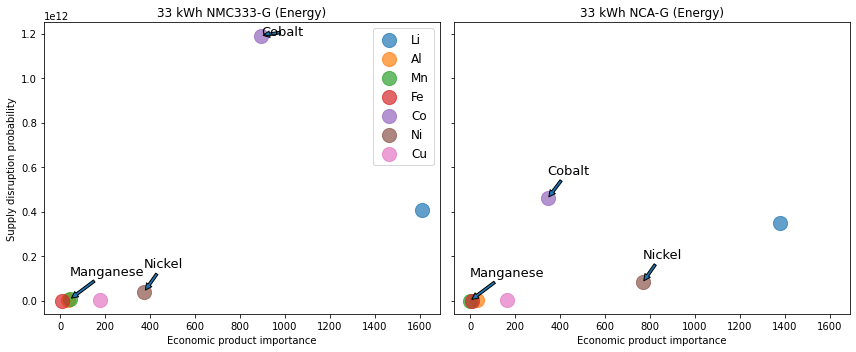

In [453]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)
for idx, element in enumerate(e):
    if SCP_scaled[0, idx]==0:
        continue
    ax[0].scatter(EPI_scaled[0, idx],SCP_scaled[0, idx], label=element, s=200, alpha=0.7)#
    ax[1].scatter(EPI_scaled[25, idx],SCP_scaled[25, idx], label=element, s=200,alpha=0.7)#
    x0, y0 = EPI_scaled[0, idx],SCP_scaled[0, idx]
    x1, y1 = EPI_scaled[25, idx],SCP_scaled[25, idx]
    if element == 'Co':
        ax[0].annotate('Cobalt',(x0,y0),xytext = (x0-0.03,y0),  arrowprops = dict(arrowstyle="simple"), fontsize=13)
        ax[1].annotate('Cobalt',(x1,y1),xytext = (x1-0.01,y1+0.11*1e12),  arrowprops = dict(arrowstyle="simple"), fontsize=13)
    if element == 'Ni':
        ax[0].annotate('Nickel',(x0,y0),xytext = (x0-0.01,y0+0.11*1e12),  arrowprops = dict(arrowstyle="simple"), fontsize=13)
        ax[1].annotate('Nickel',(x1,y1),xytext = (x1-0.01,y1+0.11*1e12),  arrowprops = dict(arrowstyle="simple"), fontsize=13)
    if element == 'Mn':
        ax[0].annotate('Manganese',(x0,y0),xytext = (x0-0.01,y0+0.11*1e12),  arrowprops = dict(arrowstyle="simple"), fontsize=13)
        ax[1].annotate('Manganese',(x1,y1),xytext = (x1-0.001,y1+0.11*1e12),  arrowprops = dict(arrowstyle="simple"), fontsize=13)

ax[0].legend(fontsize = 12)
ax[0].set_xlabel('Economic product importance')
ax[1].set_xlabel('Economic product importance')
ax[0].set_ylabel('Supply disruption probability')
for idx, design in enumerate([0, 25]):
    ax[idx].set_title (f"{int(param_dict_all[design]['pack_energy_kWh'])} kWh {param_dict_all[design]['electrode_pair']}", fontsize=12)

fig.tight_layout()

In [477]:
# # #EXPORT ALL DATA FOR FIGURES:
# C_scaled = np.einsum("ij, iej -> iej", s_nested, C_matrix_nested[:, :, process_selection])

# pd.DataFrame(C_scaled.sum(axis=1), D, p_selection_name).to_csv(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\df_materials.csv")
# pd.DataFrame(F_monetary_nested.sum(axis=2), D, f).to_csv(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\df_factors.csv")
# pd.DataFrame(v_nested_scaled, D, p_selection_name).to_csv(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\df_cost.csv")
# pd.DataFrame(h_nested_scaled, D, p_selection_name).to_csv(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\process_emissions_all_pack_design.csv")
# pd.DataFrame(c_nested_scaled, D).to_csv(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\df_criticality.csv")

# np.save(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\SC_scaled.npy", SCP_scaled)
# np.save(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\EPI_scaled.npy", EPI_scaled)

Finally, the performance for each battery design is obtained from the BatPaC results

In [52]:
# Performance:
p_nested = [
    bat_design_param_dct[design]["pack_usable_energy_kWh"] / bat_design_param_dct[design]["battery_system_weight"] * 1000 for design in D
]


Overview of the carbon footprint for all 20,736 design options results by cathode chemistry on the kWh level:


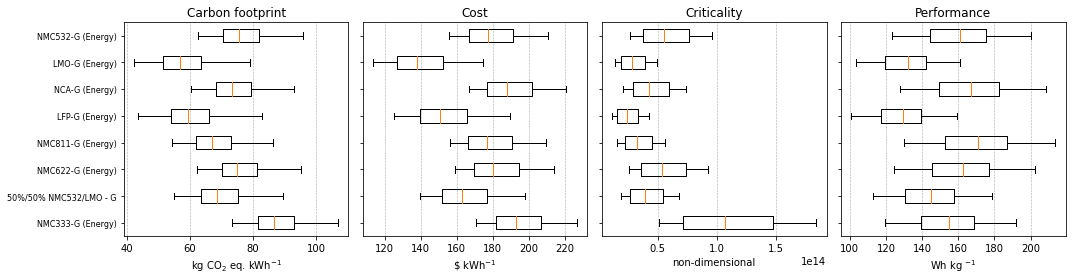

In [476]:
cathode_by_design = {design: bat_design_param_dct[design]["electrode_pair"] for design in D}
all_cathodes = set(cathode_by_design.values())

impacts_all = {
    "Carbon footprint": h_nested_scaled,
    "Cost": v_nested_scaled,
    "Criticality": c_nested_scaled,
    "Performance": p_nested,
}

fig, ax = plt.subplots(1, 4, figsize=(15, 4))
for idx, impact in enumerate(impacts_all.keys()):
    if impact != "Performance":
        impacts = {design: impacts_all[impact][design].sum() / bat_design_param_dct[design]["pack_energy_kWh"] for design in D}
    else:
        impacts = impacts_all[impact]
    y_values = {}
    for cathode in all_cathodes:
        y_values[cathode] = [impacts[x] for x in cathode_by_design.keys() if cathode_by_design[x] == cathode]
    ax[idx].boxplot(y_values.values(), vert=False)
    ax[idx].set_title(impact)
    ax[idx].xaxis.grid(
        True,
        linestyle="--",
        lw=0.6,
    )
    ax[idx].set_yticklabels([])
ax[0].set_xlabel(r"kg CO$_2$ eq. kWh$^{-1}$")
ax[1].set_xlabel(r"\$ kWh$^{-1}$")
ax[2].set_xlabel(r"non-dimensional")
ax[3].set_xlabel(r"Wh kg $^{-1}$")

ax[0].set_yticklabels(all_cathodes, fontsize=8, rotation=0)

fig.tight_layout()


### <b>Solution 2:</b> Optimal design


Next we establish a simple multi-objective optimisation problem to find the optimal design configurations.

#### Prepare data


The first step is to convert the nested matrices to a 2D matrix. 

The battery production processes are thereby added to the columns and referred to by the battery design index. For example, module and pack assembly of battery design 1 is referred to as "module and pack assembly 1". 

To reduce the total amount of columns and rows, the battery production processes for each design are aggregated into one process "battery production design x". 

In [398]:
# As the
segment_choice = range(int(len(D) / 4) * 2, int(len(D) / 4) * 4)
# segment_choice = "test"
country_selection = "European average"

In [399]:
# New good index removing the internal goods:
g_new = [i for i in g if i not in IndexTable.loc["Internal_goods", "Classification"].Items]
#exclude battery and cell from goods as they are battery design specific:
g_new.pop(g_new.index('battery jacket'))
g_new.pop(g_new.index('cell container'))


#New process index
p_new = []
# New battery production process index:
bp_new = []

# New battery process names based on design
if segment_choice == "test":
    segment_choice = list(range(0, 5))
    for d in segment_choice:
        p_new.append(f'Battery production design {d}')
        bp_new.append(f'Battery production design {d}')
else:
    for d in segment_choice:
        p_new.append(f'Battery production design {d}')
        bp_new.append(f'Battery production design {d}')
    
for x in p:
    if x in bp:#exclude internal processes
        continue
    if x == 'battery jacket production' or x == 'cell container production': #Exclude jacket production
        continue
    p_new.append(x)

# Select only regional electricity and gas
for country in r:
    if country != country_selection:
        p_new.pop(p_new.index(f"market group for electricity battery production, medium voltage, {country}"))
        p_new.pop(p_new.index(f"market group for heat, district or industrial, natural gas, {country}"))
        


In [400]:
# Empty A matrix:
A_matrix = np.zeros((len(g_new), len(p_new)))

batt_manuf_index = [p.index(x) for x in bp]

# Aggregate battery production process inputs into one process
for idx, battery_model in enumerate(segment_choice):
    A_matrix[:, idx] = A_matrix_nested[battery_model, :, batt_manuf_index].T[[g.index(x) for x in g_new]].sum(axis=1)
    #Include battery and cell jacket which has to be multiplied by the total jacket weight:
    A_matrix[:, idx] += A_matrix_nested[battery_model, [g.index(x) for x in g_new], p.index('battery jacket production')]*-A_matrix_nested[battery_model, g.index('battery jacket'), p.index('module and pack assembly')]
    A_matrix[:, idx] += A_matrix_nested[battery_model, [g.index(x) for x in g_new], p.index('cell container production')]*-A_matrix_nested[battery_model, g.index('cell container'), p.index('jelly roll enclosing')]

# Include base module values to A matrix
for process in p_new:
    if "Battery production design" not in process:
 

        A_matrix[:, p_new.index(process),] = ParameterDict[
            "4_UPI_foreground_base"
        ].Values[[g.index(x) for x in g_new], p.index(process)]
        
#Set battery pack to 1 unit:

A_matrix[g_new.index("battery pack"), 0 : len(segment_choice)] = 1

Flatten satellite account layers:

In [401]:
emission_layer = np.zeros(len(p_new))
substance_layer = np.zeros((len(p_new), len(e)))
value_added_layer = np.zeros(len(p_new))
performance_layer = np.zeros(len(p_new))



performance_layer[range(len(segment_choice))] = [
    bat_design_param_dct[design]["pack_usable_energy_kWh"] / mc_battery_design_dct[design]["battery pack"] * 1000
    for design in segment_choice
]


for idx, battery_model in enumerate(segment_choice):
    # aggregate battery design specific parameters to single process
    value_added_layer[idx] = v_nested[battery_model, batt_manuf_index].sum(axis=0)
    substance_layer[idx, :] = E_matrix_nested[battery_model, :, batt_manuf_index].sum(axis=0)
    emission_layer[idx] = h_nested[battery_model, batt_manuf_index].sum()
    # add cell and pack jacket production to battery production process:
    value_added_layer[idx] += v_nested[battery_model, p_selection_name.index('battery jacket production')]*-A_matrix_nested[battery_model, g.index('battery jacket'), p.index('module and pack assembly')]
    value_added_layer[idx] += v_nested[battery_model, p_selection_name.index('cell container production')] *-A_matrix_nested[battery_model, g.index('cell container'), p.index('jelly roll enclosing')]
    
    substance_layer[idx, :] += E_matrix_nested[battery_model, :, p_selection_name.index('battery jacket production')] *-A_matrix_nested[battery_model, g.index('battery jacket'), p.index('module and pack assembly')]
    substance_layer[idx, :] += E_matrix_nested[battery_model, :, p_selection_name.index('cell container production')] *-A_matrix_nested[battery_model, g.index('cell container'), p.index('jelly roll enclosing')]
    
    emission_layer[idx] += h_nested[battery_model, p_selection_name.index('battery jacket production')] *-A_matrix_nested[battery_model, g.index('battery jacket'), p.index('module and pack assembly')]
    emission_layer[idx] += h_nested[battery_model, p_selection_name.index('cell container production')] *-A_matrix_nested[battery_model, g.index('cell container'), p.index('jelly roll enclosing')]
                                                    
        
    

# Append non design specific parameters:
excluded_processes = (
    [f"market group for electricity battery production, medium voltage, {country}" for country in r if country != country_selection]
    + [f"market group for heat, district or industrial, natural gas, {country}" for country in r if country != country_selection]
    + bp
    + ['battery jacket production', 'cell container production']
)

for process in p:
    if process not in excluded_processes:
        value_added_layer[p_new.index(process)] = v_nested[0, p.index(process)]
        emission_layer[p_new.index(process)] = h_nested[0, p.index(process)]
        # substance_layer[p_new.index(process),:] = E_matrix_nested[0, :,p.index(process)]


#### Set up Pyomo model


In [402]:
# A_matrix = A_matrix.round(5)

# Pyomo model class:
model = pyo.ConcreteModel("battery_design_model")

#short cuts:
CF_essenz = ParameterDict["6_CR_ESSENZ_CF_elements"].Values
mineral_prices = ParameterDict['3_PR_mineral_price'].Values[:,1]

#final demand vector, 1 battery:
df_y = pd.DataFrame(np.zeros(len(g_new)), index=g_new)
df_y.loc["battery pack"] = 1


# Supply vector as pyomo variable:
model.x = pyo.Var(p_new, domain=pyo.NonNegativeReals)

# Change battery production processes to integers (only 1 whole battery can be produced.. )
for process in range(0, len(segment_choice)):
    model.x[p_new[process]].domain = pyo.NonNegativeIntegers



Objectives:

In [505]:
# A_matrix = A_matrix.round(5)

# Pyomo model class:
model = pyo.ConcreteModel("battery_design_model")

# short cuts:
CF_essenz = ParameterDict["6_CR_ESSENZ_CF_elements"].Values
mineral_prices = ParameterDict["3_PR_mineral_price"].Values[:, 1]

# final demand vector, 1 battery:
df_y = pd.DataFrame(np.zeros(len(g_new)), index=g_new)
df_y.loc["battery pack"] = 1


# Supply vector as pyomo variable:
model.x = pyo.Var(p_new, domain=pyo.NonNegativeReals)

# Change battery production processes to integers (only 1 whole battery can be produced.. )
for process in range(0, len(segment_choice)):
    model.x[p_new[process]].domain = pyo.NonNegativeIntegers


# Objective functions, written as variables and constraint for the multi-objective optimisation:
model.gwp = pyo.Var()
model.cost = pyo.Var()
model.performance = pyo.Var()

model.criticality = pyo.Var()


model.C_cost = pyo.Constraint(expr=model.cost == sum(model.x[process] * value_added_layer[p_new.index(process)] for process in p_new))
model.C_gwp = pyo.Constraint(expr=model.gwp == sum(model.x[process] * emission_layer[p_new.index(process)] for process in p_new))

model.C_performance = pyo.Constraint(
    expr=model.performance == sum(model.x[process] * performance_layer[p_new.index(process)] for process in p_new)
)
model.q = pyo.Var(initialize=0)

model.C_crit = pyo.Constraint(
    expr=model.criticality
    == sum(
        sum(
            model.x[process]
            * (
                (substance_layer[p_new.index(process), e.index(element)] * mineral_prices[e.index(element)])*-1
                * (substance_layer[p_new.index(process), e.index(element)] * CF_essenz[e.index(element)])*-1)            
            for element in e
        )
        for process in p_new
    )
)

model.O_criticality = pyo.Objective(expr=model.criticality, sense=pyo.minimize)
model.O_gwp = pyo.Objective(expr=model.gwp, sense=pyo.minimize)
model.O_cost = pyo.Objective(expr=model.cost, sense=pyo.minimize)
model.O_performance = pyo.Objective(expr=model.performance, sense=pyo.maximize)


Constraints:


In [506]:

def material_balance(model, good):
    """Mass balance and demand constraint"""
    if good == 'battery production scrap':
        return pyo.Constraint.Skip
    mb = sum(model.x[process] * A_matrix[g_new.index(good), p_new.index(process)] for process in p_new) == float(df_y.loc[good])
    if mb is True:
        return pyo.Constraint.Skip
    return mb


def material_balance_waste(model, waste):
    """Mass balance and demand constraint"""
    mb = sum(model.x[process] * A_matrix[g_new.index(waste), p_new.index(process)] for process in p_new) >= float(df_y.loc[waste])
    if mb is True:
        return pyo.Constraint.Skip
    return mb

model.material_balance = pyo.Constraint(g_new, rule=material_balance)
model.material_balance_waste = pyo.Constraint(["battery production scrap"], rule=material_balance_waste)


#### Result of single objective optimisation 

Optimising each objective function to obtain the pay-off table:

In [507]:
# Get all objective functions
objectives = [x for x in model.component_objects() if x.is_named_expression_type() == True]

# deactivate all:
[objective.deactivate() for objective in objectives]

df = pd.DataFrame(
    index=[
        "Cost",
        "Carbon footprint",
        "Performance",
        "Criticality",
        "Pack design",
        "Pack weight",
        "Vehicle weight",
        "Pack capacity",
        "Vehicle segment",
        "Cathode chemistry",
        "Graphite",
        "Separator",
        "Separator coating",
        "Cell thickness",
        "Silicon additive",
        "Cathode foil",
        "Anode foil",
    ]
)
df["Unit"] = [
    "$",
    "CO\N{SUBSCRIPT TWO}-eq.",
    "Wh kg\N{SUPERSCRIPT ONE}",
    "Non-dimensional",
    "Category",
    "kg",
    "kg",
    "kWh",
    "Segment",
    "Category",
    "Category",
    "um",
    "um",
    "cm",
    "wt%",
    "um",
    "um",
]

# Iterate through all:
for objective in objectives:
    objective.activate()
    print(f"Solving {objective.name}")
    pyo.SolverFactory("cplex").solve(model, logfile="some_file_name.log")
    for process in p_new:
        if model.x[process].value > 0 and 'Battery production design' in process:
            design = int(process.split('design ')[1])

    df[objective.name] = [
        round(pyo.value(model.cost), 2),
        round(pyo.value(model.gwp), 2),
        round(pyo.value(model.performance), 2),
        round(pyo.value(model.criticality), 2),
        design,
        round(bat_design_param_dct[design]["battery_system_weight"], 1),
        round(bat_design_param_dct[design]["vehicle_weight"], 0),
        round(bat_design_param_dct[design]["pack_energy_kWh"], 3),
        0,
        bat_design_param_dct[design]["electrode_pair"],
        bat_design_param_dct[design]["graphite_type"],
        bat_design_param_dct[design]["sep_film_thickness"],
        bat_design_param_dct[design]["sep_coat_thickness"],
        bat_design_param_dct[design]["cell_thickness_target"],
        bat_design_param_dct[design]["silicon_anode"],
        bat_design_param_dct[design]["positive_foil_thickness"],
        bat_design_param_dct[design]["negative_foil_thickness"],
    ]
    objective.deactivate()
print ('Pay-off table:')
df


Solving O_criticality
Solving O_gwp
Solving O_cost
Solving O_performance
Pay-off table:


,Unit,O_criticality,O_gwp,O_cost,O_performance
Cost,$,12286.33,11177.01,10611.01,18625.44
Carbon footprint,CO₂-eq.,4107.39,3969.74,4501.12,6249.53
Performance,Wh kg¹,151.14,153.16,146.86,213.72
Criticality,Non-dimensional,2594006220266485.5,3088810462846026.0,3152978481159077.5,6207532030313358.0
Pack design,Category,10402,10414,13103,15574
Pack weight,kg,552.5,544.3,570.6,506.5
Vehicle weight,kg,2227.0,2215.0,2256.0,2334.0
Pack capacity,kWh,88.837,88.691,89.162,115.183
Vehicle segment,Segment,0,0,0,0
Cathode chemistry,Category,LFP-G (Energy),LMO-G (Energy),LMO-G (Energy),NMC811-G (Energy)


In [492]:
def ShowSingle (X,J, Index):
    return pd.DataFrame.from_records([[X[j].value] for j in J], index=Index)


def ShowDouble(X,T,J, Index, Columns):
    try:
        return pd.DataFrame.from_records([[X[t,j].value for t in T] for j in J], index=Index, columns=Columns)
    except:
        return pd.DataFrame.from_records([[X[t,j] for t in T] for j in J], index=Index, columns=Columns)

def ShowTriple( X, I,J,K, names ):
    index = pd.MultiIndex.from_product([I,J], names=names)
    return pd.DataFrame.from_records([[X[i,j,k].value for k in K ] for i in I for j in J ],index=index,columns=K )

As you can see there is a clear trade-off with, on the one hand, the carbon footprint, cost and criticality objectives and, on the other hand, the performance objective:

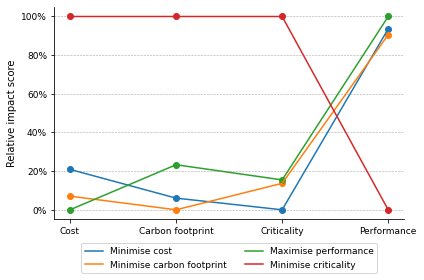

In [510]:
df_payoff = df.loc[
    [
        "Cost",
        "Carbon footprint",
            "Criticality",
        "Performance",
    ]
].drop("Unit", axis=1)

df_payoff.loc["Performance"] = 1000 - df_payoff.loc["Performance"]
df_normalised = pd.DataFrame()
for row in df_payoff.index:
    df_normalised[row] = (df_payoff.loc[row] - df_payoff.loc[row].min()) / (df_payoff.loc[row].max() - df_payoff.loc[row].min())

df_normalised = df_normalised.reset_index().drop("index", axis=1)

df_normalised = df_normalised.T * 100


fig, ax = plt.subplots(
    1,
    1,
)
import matplotlib.ticker as mtick

ax.yaxis.set_major_formatter(mtick.PercentFormatter())


ax.plot(df_normalised.index, df_normalised.values[:, 0], label="Minimise cost")
ax.scatter(df_normalised.index, df_normalised.values[:, 0])
ax.plot(df_normalised.index, df_normalised.values[:, 1], label="Minimise carbon footprint")
ax.scatter(df_normalised.index, df_normalised.values[:, 1])
ax.plot(df_normalised.index, df_normalised.values[:, 2], label="Maximise performance")
ax.scatter(df_normalised.index, df_normalised.values[:, 2])
ax.plot(df_normalised.index, df_normalised.values[:, 3], label="Minimise criticality")
ax.scatter(df_normalised.index, df_normalised.values[:, 3])

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.grid(True, linestyle="--", lw=0.6)
ax.set_ylabel("Relative impact score")
ax.set_axisbelow(True)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.09), fancybox=True, ncol=2, fontsize=9)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# ax.set_ylim([0,101])
fig.tight_layout()


#### Multi-objective optimisation 

Next, multi-objective optimisation is used to identify the optimal design configuration.

Following the clear trade-offs between performance and the other objective functions, we use the Epsilon constraint method to find the optimal design configurations between the performance objective and each other objective



Obtain the min and max of each objective combination:

In [514]:
try:
    del model.eq2
    del model.epsilon
except:
    pass

# Epsilon parameter:
model.epsilon = pyo.Param(initialize=1000000, mutable=True)


# Get all objective functions
objectives = [x for x in model.component_objects() if x.is_named_expression_type() == True]

# deactivate all:
[objective.deactivate() for objective in objectives]

min_max_values = {}

for objective in objectives:
    try:
        del model.eq2
    except:
        pass
    name = objective.name
    if name == 'O_performance':
        continue
    variable_name = name.strip('O_')
    model_variable = [x for x in model.component_objects() if x.getname() == variable_name][0]
    objective.activate()
    solver = pyo.SolverFactory("cplex")
    print ('Solving for', objective)
    solver.solve(model)
    print (objective,  pyo.value(model_variable))
    print ('O_performance:', pyo.value(model.performance))
    
    # max of selected objective, min of performance:
    min_max_values [variable_name] = [[pyo.value(model_variable), pyo.value(model.performance)]]
    objective.deactivate()
    
    #Solve for performance:
    model.O_performance.activate()
    print ('Solving for O_performance')
    solver.solve(model)
    print (objective, pyo.value(model_variable))
    print ('O_performance:', pyo.value(model.performance))
    min_max_values[variable_name].append([pyo.value(model_variable), pyo.value(model.performance)])
    model.O_performance.deactivate()

Solving for O_criticality
O_criticality 2594006220266485.5
O_performance: 151.13588951845296
Solving for O_performance
O_criticality 6207532030313358.0
O_performance: 213.72063679534358
Solving for O_gwp
O_gwp 3969.7355735310616
O_performance: 153.16219518032557
Solving for O_performance
O_gwp 6249.533513339715
O_performance: 213.72063679534358
Solving for O_cost
O_cost 10611.010758679095
O_performance: 146.86205456704005
Solving for O_performance
O_cost 18625.4389316909
O_performance: 213.72063679534358


In [512]:
model.O_performance.activate()


steps = 5
X = {}
Y = {}
design_choice = {}

p_values = []

for objective in min_max_values.keys():
    min_obj2 = min_max_values[objective][0][0]
    max_obj2 = min_max_values[objective][1][0]
    X[objective] = []
    Y[objective] = []
    design_choice[objective] = []
    print("Objectives: performance + ", objective)
    print(" OBJ1 ", "  OBJ2 ", " Epsilon ")
    for counter in range(1, steps + 1):
        try:
            del model.epsilon
            del model.eq2
        except:
            pass
        obj_1 = [x for x in model.component_objects() if x.getname() == objective][0]
        obj_2 = model.performance
        model.epsilon = min_obj2 + (max_obj2 - min_obj2) * (counter - 1) / (steps - 1)
        model.eq2 = pyo.Constraint(expr=obj_1 <= model.epsilon)
        solver.solve(model) 
        design = [design for design in p_new if model.x[design].value > 0]
        print("%5.2f" % pyo.value(obj_1), "%5.2f" % pyo.value(obj_2), "%5.2f" % pyo.value(model.epsilon), design[0])
        Y[objective].append(pyo.value(obj_1))
        X[objective].append(pyo.value(obj_2))
        design_choice[objective].append(design[0])


Objectives: performance +  criticality
 OBJ1    OBJ2   Epsilon 
2594006220266485.50 151.14 2594006220266485.50 Battery production design 10402
3472552492214797.00 201.14 3497387672778203.50 Battery production design 10390
3472552492214797.00 201.14 4400769125289922.00 Battery production design 10390
3472552492214797.00 201.14 5304150577801640.00 Battery production design 10390
6207532030313358.00 213.72 6207532030313358.00 Battery production design 15574
Objectives: performance +  gwp
 OBJ1    OBJ2   Epsilon 
3969.74 153.16 3969.74 Battery production design 10414
3969.74 153.16 4539.69 Battery production design 10414
4873.40 201.14 5109.63 Battery production design 10390
4873.40 201.14 5679.58 Battery production design 10390
6249.53 213.72 6249.53 Battery production design 15574
Objectives: performance +  cost
 OBJ1    OBJ2   Epsilon 
10611.01 146.86 10611.01 Battery production design 13103
11177.01 153.16 12614.62 Battery production design 10414
14454.12 201.14 14618.22 Battery produc

Visualise the Pareto optimal:

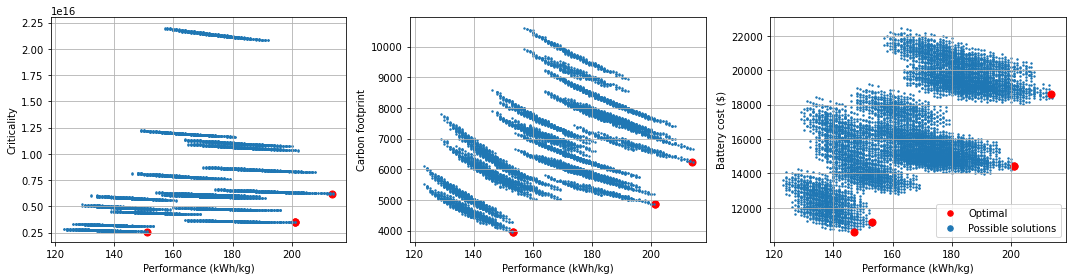

In [528]:
from scipy.interpolate import make_interp_spline


fig, ax = plt.subplots(1, len(min_max_values), figsize=(15,4))

for idx, objective in enumerate(min_max_values.keys()):
    y = X[objective]
    x = Y[objective]
    ax[idx].scatter(y,x, c='r', label='Optimal',s=50)
    ax[idx].grid()
    ax[idx].set_xlabel('Performance (kWh/kg)' )
    
ax[1].scatter(performance_layer[range(len(segment_choice))].round(0), h_nested_scaled[segment_choice].sum(1).round(0), label='Possible solutions', s=2)
ax[2].scatter(performance_layer[range(len(segment_choice))].round(0), v_nested_scaled[segment_choice].sum(1).round(0), label='Possible solutions', s=2, zorder=0)
ax[0].scatter(performance_layer[range(len(segment_choice))].round(0), c_nested_scaled[segment_choice].round(0), label='Possible solutions', s=2)


ax[0].set_ylabel("Criticality")

ax[1].set_ylabel("Carbon footprint")
ax[2].set_ylabel("Battery cost ($)")


lgnd = plt.legend(loc="lower right", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
fig.tight_layout()


### Parameter sensitivity

##### Cost

| Parameter | Unit| Lower bound | Used in study|  Upper bound  |
|--------------------|---------------|-----------------------|------------------------|------------------------|
| Location           | Country       | Norway               | Average                | Hungary                 |
| Capacity           | packs/year    | 700,000              | 500,000                | 100,000                |
| Nickel price       | \$/element    | 7.05                  | 24.39                  | 65.13                  |
| Aluminium price    | \$/element    | 1.146                 | 2.81                   | 3.69                   |
| Phosphorus price   | \$/element    | 2.81                  | -                      | 27.81                  |
| Iron price         | \$/element    | 0.11                  | 0.19                   | 0.63                   |
| Lithium price      | \$/element    | 22.48                 | 225.48                 | 361.78                 |
| Manganese price    | \$/element    | 3.31                  | 4.82                   | 14.6                   |
| Cobalt price       | \$/element    | 8.9                   | 76.32                  | 114.22                 |



In [542]:
# new cost array of size low/high scenario (2) X parameters (9) X designs (20736) 
v_scaled_sens = np.zeros([2, 9, v_nested_scaled.shape[0]])

Update production location by multiplying the physical factor requirement with the country specific factor cost. 

The cheapest and most expensive production countries on average are Hungary and Poland:

In [916]:
#Selected country:
countries = r

country_cost= np.zeros([len(r), len(D)])
# for scenario_idx, scenario in enumerate(['low', 'high']):
for country in countries:
    factor_cost = ParameterDict["3_PR_factor_price"].Values[:, IndexTable.loc["Regions", "Classification"].Items.index(country)]
    F_monetary_nested_SA = np.einsum(
        "dfp, f -> dfp", F_physical_nested, (factor_cost * list(bat_cost.factor_overhead_multiplier(return_index=f).values()))
    )/manufacturing_capacity
    #Update material cost matrix to regional energy cost, to avoid recalculating the S vector, the European average price is simply updated:
    v_nested[:, p.index('market group for electricity battery production, medium voltage, European average')] = ParameterDict['3_PR_regional_energy_price'].Values[0, r.index(country)]
    v_nested[:, p.index("market group for heat, district or industrial, natural gas, European average")] = ParameterDict['3_PR_regional_energy_price'].Values[1, r.index(country)]
    # process value added based on factor requirements:
    v_nested = np.sum(F_monetary_nested_SA, 1)
    # material process value added based on C matrix:
    v_nested[:] += np.sum(C_matrix_nested, 1)
    country_cost[countries.index(country)] =  np.einsum("ij, ij -> i", s_nested, v_nested[:, process_selection])

pd.DataFrame(country_cost.mean(axis=1),  r).sort_values(by=0)

In [928]:
#Append the low and high cost vectors to the updated v scaled layer:
v_scaled_sens[0, 0] =  country_cost[r.index('HU')]
v_scaled_sens[1, 0] =  country_cost[r.index('NO')]

Update production capacity by updating the physical factor requirement matrix:

In [929]:
production_capacities = [100000, 700000]

for scenario, capacity in enumerate(production_capacities):
    # Change the capacity parameter for all battery designs
    for x in param_dict_all.keys():
        param_dict_all[x]["battery_manufacturing_capacity"] = capacity
    # Returns the nested F matrix with factors (rows) for all battery production processes (columns)
    F_physical_nested_temp = bat_cost.factors_battery_production(param_dict_all, run_multiple=True, return_index=f, return_columns=bp)
    # Include all foreground processes:
    F_physical_nested_SA = np.zeros([len(D), len(f), len(p)])
    F_physical_nested_SA[:, :, [p.index(process) for process in set(bat_cost.process_mapping.values())]] = F_physical_nested_temp
    factor_cost = ParameterDict["3_PR_factor_price"].Values[:, IndexTable.loc["Regions", "Classification"].Items.index('European average')]
    F_monetary_nested_SA = np.einsum(
        "dfp, f -> dfp", F_physical_nested_SA, (factor_cost * list(bat_cost.factor_overhead_multiplier(return_index=f).values()))
    )/capacity
    # process value added based on factor requirements:
    v_nested = np.sum(F_monetary_nested_SA, 1)
    # material process value added based on C matrix:
    v_nested[:] += np.sum(C_matrix_nested, 1)
    v_scaled_sens[scenario, 1] =  np.einsum("ij, ij -> i", s_nested, v_nested[:, process_selection])

100%|██████████| 20736/20736 [03:49<00:00, 90.20it/s] 


Finally, update the cathode material prices based on the lowest and highest mineral prices of the last 20 years in the material cost matrix ($\bf{C}$). 

The cathode material price ($/kg) is based on the process cost and profit margin (PCPM) and a defined mineral price scenario ($s$) multiplied by the elemental content of the cam ($\tau$) :
$$ cathode\_cost_{cam} = PCPM_{cam}+ (mineral\_cost_{e,s} \times \tau_{e,cam}) $$

Where the PCPM is based on the current cathode material price as reported by the SMM and the mineral costs:

$$ PCPM = cathode\_cost_{current} \times (mineral\_cost_{e,current} \times \tau_{e,cam})$$


In [1078]:
# Calculate the PCPM:
cathodes_idx = [g.index(x) for x in g if 'cathode active material' in x]
df_elements_cam = pd.DataFrame(ParameterDict['3_MC_element_goods'].Values[:, cathodes_idx].T,[g[x] for x in cathodes_idx], e)

cam_prices_default = df_pr_material_mass.loc [[g[x] for x in cathodes_idx]].to_dict()
default_pcpm = bat_cost.process_cost_profit_margin_cam(df_elements_cam,cam_prices_default, dict(zip(e, ParameterDict['3_PR_mineral_price'].Values[:,1])), return_pcpm=True )

# Update the CAM price for each price scenario (low, high) and element (Li, P, Mn, Co, Fe, and Ni):
considered_elements = ['Li', 'P', 'Mn', 'Co', 'Fe', 'Ni']
price_scenario = ['low', 'high']

metal_price_dict = dict(zip(e, ParameterDict['3_PR_mineral_price'].Values[:,1]))

for scenario_idx, scenario in enumerate(price_scenario):
    for element_idx, element in enumerate(considered_elements):
        #low price:
        metal_price_dict[element] = ParameterDict['3_PR_mineral_price'].Values[e.index(element),IndexTable.loc['Mineral_price_scenario', 'Classification'].Items.index(scenario)]
        # Calculate new CAM price:
        cam_price_dict = bat_cost.cam_price(metal_cost =metal_price_dict, elemental_content_df =  df_elements_cam, pcpm_cam=default_pcpm)
        # Multiply the CAM price by the overhead to material multiplier:
        cam_price_dict = {k:v*bat_cost.material_overhead_multiplier() for k,v in cam_price_dict.items()}
        # update cam prices in the C matrix:
        for cath in cathodes_idx:
            process_index = np.where(C_matrix_nested[1, cath] >0)[0][0]
            C_matrix_nested[:, cath, process_index] = cam_price_dict[g[cath]]
        #Add updated cam price to new cost vector:
        v_nested = np.sum(F_monetary_nested, 1)
        # material process value added based on C matrix:
        v_nested[:] += np.sum(C_matrix_nested, 1)
        v_scaled_sens[scenario_idx, element_idx+2] = np.einsum("ij, ij -> i", s_nested, v_nested[:, process_selection])
        #restore metal price value to original:
        metal_price_dict[element] = ParameterDict['3_PR_mineral_price'].Values[e.index(element),1]
#Restore C_matrix prices:
for cath in cathodes_idx:
    process_index = np.where(C_matrix_nested[1, cath] >0)[0][0]
    C_matrix_nested[:, cath, process_index] = cam_prices_default[g[cath]] *bat_cost.material_overhead_multiplier()



Establishing a dataframe with all average cost per cathode chemistry:

In [1091]:
cathodes = list(set([bat_design_param_dct[design]["electrode_pair"] for design in D]))
scenarios = ["low", "low std", "used", "high", "high std"]

df_SA_cost = pd.DataFrame(
    index=[np.repeat(cathodes, len(scenarios)), scenarios * len(cathodes)],
    columns=[
        "production location",
        "production capacity",
        "Li",
        "P",
        "Mn",
        "Fe",
        "Co",
        "Ni",
    ],
)

def mean_all(cathode, values, design_range=None):
    if design_range is None:
        design_range = D
    return_value = [
        values[design] / bat_design_param_dct[design]["pack_energy_kWh"]
        for design in design_range
        if bat_design_param_dct[design]["electrode_pair"] == cathode
    ]
    return np.mean(return_value)

def std_all(cathode, values, design_range=None):
    if design_range is None:
        design_range = D
    return_value = [
        values[design] / bat_design_param_dct[design]["pack_energy_kWh"]
        for design in design_range
        if bat_design_param_dct[design]["electrode_pair"] == cathode
    ]
    return np.std(return_value)

for cathode in cathodes:
    base = mean_all(cathode, v_nested_scaled.sum(axis=1))
    base_std = std_all(cathode, v_nested_scaled.sum(axis=1))
    df_SA_cost.loc[cathode, "used"] = base
    
    df_SA_cost.loc[cathode, "low"]["production location"] = mean_all(cathode, v_scaled_sens[0, 0])
    df_SA_cost.loc[cathode, "low std"]["production location"] = std_all(cathode, v_scaled_sens[0, 0]) - base_std
    df_SA_cost.loc[cathode, "high"]["production location"] = mean_all(cathode, v_scaled_sens[1, 0])
    df_SA_cost.loc[cathode, "high std"]["production location"] = std_all(cathode, v_scaled_sens[1, 0]) - base_std
    
    df_SA_cost.loc[cathode, "low"]["production capacity"] = mean_all(cathode, v_scaled_sens[1, 1])
    df_SA_cost.loc[cathode, "low std"]["production capacity"] = std_all(cathode, v_scaled_sens[1, 1]) - base_std
    df_SA_cost.loc[cathode, "high"]["production capacity"] = mean_all(cathode, v_scaled_sens[0, 1])
    df_SA_cost.loc[cathode, "high std"]["production capacity"] = std_all(cathode, v_scaled_sens[0, 1]) - base_std
    
    for material_i, material in enumerate(considered_elements):
        material_i += 2
        mean_high = mean_all(cathode, v_scaled_sens[1, material_i])
        std_high = std_all(cathode, v_scaled_sens[1, material_i])
        mean_low = mean_all(cathode, v_scaled_sens[0, material_i])
        std_low = std_all(cathode, v_scaled_sens[0, material_i])

        df_SA_cost.loc[cathode, "high"][material] = mean_high
        df_SA_cost.loc[cathode, "high std"][material] = std_high - base_std
        df_SA_cost.loc[cathode, "low"][material] = mean_low
        df_SA_cost.loc[cathode, "low std"][material] = std_low - base_std
df_SA_cost

production location production capacity  \
NMC333-G (Energy)      low               183.105672          187.213601   
                       low std            -0.784412            0.109626   
                       used              193.258075          193.258075   
                       high               193.61872          193.533567   
                       high std             1.40979            1.191173   
50%/50% NMC532/LMO - G low                155.03851          159.254828   
                       low std            -0.782279            0.108699   
                       used              163.151229          163.151229   
                       high              165.826321          165.737207   
                       high std            1.406891            1.199444   
NMC622-G (Energy)      low               171.634736          175.632382   
                       low std            -0.782734            0.110465   
                       used              181.074003          181.074003   
                       high               181.86867          181.788685   
                       high std            1.407986            1.182192   
NMC811-G (Energy)      low               168.324953          172.211892   
                       low std            -0.779006            0.111571   
                       used               177.59336           177.59336   
                       high              178.278773          178.202611   
                       high std            1.404105             1.17237   
LFP-G (Energy)         low               144.033235          148.823262   
                       low std            -0.804323            0.102073   
                       used              151.383218          151.383218   
                       high              156.248935          156.067504   
                       high std            1.430731            1.242914   
NCA-G (Energy)         low               178.396928          182.321989   
                       low std            -0.780427             0.11139   
                       used              188.310741          188.310741   
                       high              188.447827          188.371539   
                       high std            1.406088            1.175988   
LMO-G (Energy)         low                131.62515          136.180815   
                       low std             -0.78733            0.104178   
                       used              138.276148          138.276148   
                       high              143.268679          143.148188   
                       high std            1.408458            1.220228   
NMC532-G (Energy)      low               168.669464          172.688025   
                       low std            -0.783358            0.110183   
                       used              177.901988          177.901988   
                       high              178.956295          178.875283   
                       high std             1.40842            1.183876   

                                         Li           P          Mn  \
NMC333-G (Energy)      low       146.185635  193.258075  193.126128   
                       low std     0.015358         0.0    0.000043   
                       used      193.258075  193.258075  193.258075   
                       high      193.258075  193.258075  197.257392   
                       high std         0.0         0.0   -0.001304   
50%/50% NMC532/LMO - G low       122.248545  163.151229  162.862997   
                       low std     0.012497         0.0    0.000088   
                       used      163.151229  163.151229  163.151229   
                       high      163.151229  163.151229  171.887543   
                       high std         0.0         0.0   -0.002667   
NMC622-G (Energy)      low       138.939666  181.074003  181.003068   
                       low std     0.014078        -0.0    0.000024   
                       used      

Visualise the results:

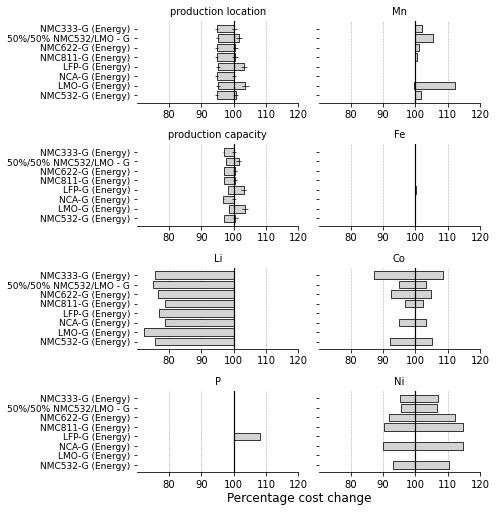

In [1088]:
# Change dataframe to percentages:

for cath in df_SA_cost.index.levels[0]:
    mean = df_SA_cost.loc[cath, 'used']['Ni']
    df_SA_cost.loc[cath ] = df_SA_cost.loc[cath].values/mean*100
    
fig, ax = plt.subplots(4,2, figsize=(7, 7), sharex=True, sharey=True)

for i, column in enumerate(df_SA_cost.columns):
    if i >3:
        i_1 = 1
        i_2 = i-4
    else:
        i_1 = 0
        i_2 = i
    df_temp = df_SA_cost[column]
    mean = 100
    lows = [df_temp[cathode, 'low'] for cathode in all_cathodes]
    highs = [df_temp[cathode, 'high'] for cathode in all_cathodes]
    std_high  = [df_temp[cathode, 'high std']for cathode in all_cathodes]
    std_low  = [df_temp[cathode, 'low std']for cathode in all_cathodes]

    values = np.array([x1 - x2 for x1, x2 in zip(highs, lows)])

    # The y position for each variable
    ys = range(len(values))[::-1]  # top to bottom

    # Plot the bars, one by one
    for y, low, value, high, error_h, error_l in zip(ys, lows, values, highs, std_high,std_low):
        low_width = mean - low
        high_width = low + value - mean
        ax[i_2,i_1].broken_barh(
            [(low, low_width), (mean, high_width)],
            (y - 0.4, 0.8),
            facecolors=["lightgrey", "lightgrey"],  # Try different colors if you like
            linewidth=0.75,
            edgecolor = ['black', 'black']
        )
        ax[i_2,i_1].errorbar(high, y, xerr=error_h, fmt='k',  elinewidth=0.7)
        ax[i_2,i_1].errorbar(low, y, xerr=error_l, fmt='k',  elinewidth=0.7)

    ax[i_2,i_1].axvline(mean,  color="black",lw=1.2)
    ax[i_2,i_1].set_title(column, fontsize=10)
    # Position the x-axis on the top, hide all the other spines (=axis lines)
    # axes = plt.gca()  # (gca = get current axes)
    ax[i_2,i_1].spines["left"].set_visible(False)
    ax[i_2,i_1].spines["right"].set_visible(False)
    ax[i_2,i_1].spines["top"].set_visible(False)
    ax[i_2,i_1].xaxis.set_ticks_position("bottom")
    # plt.text(mean, 5.2, f'Optimal design: {int(mean)}'+' Wh kg$^{-1}$',va="bottom", ha="center")

    ax[i_2,i_1].set_xticks(np.arange(80, 120 + 1, 10))
    ax[i_2,i_1].xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
  #  Make the y-axis display the variables

    ax[i_2,i_1].set_yticks(ys)
    ax[i_2, i_1].set_yticklabels([i for i in all_cathodes],fontsize=9)


   # Set the portion of the x- and y-axes to show
    ax[i_2,i_1].xaxis.grid(True, linestyle = '--', lw=0.6)
    
    ax[i_2,i_1].set_axisbelow(True)
    
fig.text(0.6, -0.003, r"Percentage cost change", ha="center",fontsize=12, )

fig.tight_layout ()